# Import

In [1]:
import PyPDF2
import pandas as pd
import re
import numpy as np
import os
import fitz
from PIL import Image
import io
from functools import partial
import scipy
import skimage
import cv2 as cv
from scipy import ndimage as ndi
import copy
from numba import njit

from bs4 import BeautifulSoup

from collections import Counter

from sklearn.utils import shuffle
from scipy.spatial.distance import cdist

from skimage.morphology import remove_small_objects

import pylab
from matplotlib.colors import to_hex
import matplotlib.pyplot as plt

import simplekml

from skimage.io import imread
from scipy import ndimage as ndi
from skimage import feature
from skimage.color import rgb2gray 
from skimage.color.adapt_rgb import adapt_rgb, each_channel, hsv_value
import matplotlib.pyplot as plt
from skimage import filters

from skimage import data, segmentation, feature, future
from sklearn.ensemble import RandomForestClassifier
from functools import partial

from skimage.filters import median

import random
import tkinter as tk
from tkinter import ttk
from PIL import Image, ImageTk
from tkinter import Canvas

import subprocess
import geojson

import gui
import glob
import gui_exp

%pdb
%load_ext autoreload
%autoreload 2
base_dir = '/home/student.unimelb.edu.au/shorte1/Documents/ACF_consulting'

Automatic pdb calling has been turned ON


In [2]:
table = pd.read_csv(base_dir + '/example_table.csv', dtype=str, sep='\t')
table['Threatened Species'] = 'None mentioned'
table['Map'] = False
species = pd.read_csv('threatened_species_202010.csv')

Extract "Threatened Species" and "Map?" column.

In [3]:
example_folders = [x[0].replace('/','') + '_' + x[1].replace('/','') for x in table[['Reference Number', 'Date of notice']].values]

In [4]:
# Check for scientific names 
# Loop through pdf files. Convert pdf to text. Search for scientific names.
folders = os.listdir("./files")

In [5]:
folders_revised = []
for folder in folders:
    for example_folder in example_folders:
        if example_folder in folder:
            folders_revised.append(folder)

In [6]:
folders_revised = list(set(folders_revised))
len(folders_revised)

93

In [7]:
folders=folders_revised

In [66]:
# Loop through folders
for folder in folders_revised:
    print(folder)
    try:
        fn = folder.split('_')[0] + '_' + folder.split('_')[1] + '_combined.pdf'
        pdf_file_obj = open(base_dir + '/files/' + folder + '/' + fn, 'rb')
        pdf_reader = PyPDF2.PdfFileReader(pdf_file_obj)
    except:
        try:
            fn = folder + '_combined.pdf'
            pdf_file_obj = open(base_dir + '/files/' + folder + '/' + fn, 'rb')
            pdf_reader = PyPDF2.PdfFileReader(pdf_file_obj)
        except:
            continue

    try:
        pages = [
            pdf_reader.getPage(i).extractText().replace('\n', '') 
            for i in range(pdf_reader.numPages)
        ]
    except:
        continue
    text = ''.join(pages)
    
    text_lower = text.lower()
    sci_name = species['Scientific Name'].apply(lambda x: x.lower()).values
    comm_name = species['Common Name'].loc[
        np.logical_and(
            species['Common Name'] != 'a shrub', species['Common Name'] != '-'
        )
    ].apply(lambda x: x.lower()).values

    [sci_name_exist, comm_name_exist] = [
        [
            species['Common Name'].values[i] + ', ' 
            + species['Scientific Name'].values[i] + ' (' 
            +  species['Threatened status'].values[i] + ')' 
            for i in range(len(name)) if name[i] in text.lower()
        ]
        for name in [sci_name, comm_name]
    ]
    
    if 'coordinates' in text.lower() or 'latitude' in text.lower() or 'longitude' in text.lower() or ' map ' in text.lower():
        coordinates_mentioned = True
    else:
        coordinates_mentioned = False

    species_mentioned = sorted(
        list(set(sci_name_exist).union(set(comm_name_exist)))
    )
    species_mentioned = ', '.join(species_mentioned)
    
#     Extract text coordinates
#     text = re.sub('([-]?[0-9]{2}:[0-9]{2}:)([0-9]{1}).([0-9]{1})([0-9]{2})', '\g<1>\g<2>\g<3>.\g<4>', text)
#     text = re.sub('([-]?[0-9]{2}:[0-9]{2}:[0-9]{2}.[0-9]{2})([N,S]{1})', '\g<1> \g<2>', text)
#     points_lat = re.findall('[-]?[0-9]{2}:[0-9]{2}:[0-9]{2}.[0-9]{2} [N,S]{1}', text)
#     points_lon = re.findall('[-]?[0-9]{2,3}:[0-9]{2}:[0-9]{2}.[0-9]{2} [E,W]{1}', text)

    id_nums = folder.split('_')
    date = id_nums[1][:2] + '/' + id_nums[1][2:4] + '/' + id_nums[1][4:]
    ref_num = id_nums[0][:4] + '/' + id_nums[0][4:]
    table['Threatened Species'].loc[np.logical_and(
        table['Date of notice'] == date, table['Reference Number'] == ref_num
    )] = species_mentioned
    table['Map'].loc[np.logical_and(
        table['Date of notice'] == date, table['Reference Number'] == ref_num
    )] = coordinates_mentioned

NameError: name 'folders_revised' is not defined

In [13]:
table.to_csv('example_revised_table.csv', index=False, header=True)

In [20]:
coords = coords.reshape(int(len(coords)/2),2)
coords_new = np.zeros_like(coords)
coords_new[:,1] = coords[:,0]
coords_new[:,0] = coords[:,1]

In [3]:
pdf_file_obj = open('example_referral.pdf', 'rb')
pdf_reader = PyPDF2.PdfFileReader(pdf_file_obj)
pages = [pdf_reader.getPage(i).extractText().replace('\n', '') for i in range(pdf_reader.numPages)]

In [4]:
text = ''.join(pages)

Extract KML from text.

In [5]:
import fitz

In [6]:
text = re.sub('([-]?[0-9]{2}:[0-9]{2}:)([0-9]{1}).([0-9]{1})([0-9]{2})', '\g<1>\g<2>\g<3>.\g<4>', text)
text = re.sub('([-]?[0-9]{2}:[0-9]{2}:[0-9]{2}.[0-9]{2})([N,S]{1})', '\g<1> \g<2>', text)

In [7]:
text

"Referral of proposed action  Proposed action title: Yangibana Rare Earths Project  1 Summary of proposed action  1.1 Short description Hastings Technology Metals Limited (Hastings) proposes to develop the Yangibana Rare Earths Project (the Proposal), located approximately 270 km east-northeast of Carnarvon, in the Upper Gascoyne region of Western Australia (WA).  The Proposal will involve mining ferrocarbonatite-magnetite-rare earth bearing dykes.  Proposal activities include construction, mining, processing, decommissioning and rehabilitation of a rare earth mine, and associated infrastructure.  The Proposal is expected to have a mine life of approximately seven years. 1.2 Latitude and longitude Polygon enclosing entire referral area. Points are listed in a clockwise order.  Latitude Longitude Point degrees minutes seconds degrees minutes seconds 1 -23:54:44.60 S  116:05:52.08 E 2 -23:54:09.76 S  116:06:12.24 E 3 -23:52:05.05 S  116:07:43.68 E 4 -23:50:13.59 S  116:10:00.12 E 5 -23:4

In [8]:
points_lat = re.findall('[-]?[0-9]{2}:[0-9]{2}:[0-9]{2}.[0-9]{2} [N,S]{1}', text)
points_lon = re.findall('[-]?[0-9]{2,3}:[0-9]{2}:[0-9]{2}.[0-9]{2} [E,W]{1}', text)

In [9]:
def convert_to_decimal(old):
    direction = {'N':1, 'S':-1, 'E': 1, 'W':-1}
    new = old.replace(':',' ')
    new = new.split()
    new_dir = new.pop()
    return (abs(float(new[0]))+float(new[1])/60.0+float(new[2])/3600.0) * direction[new_dir]

In [10]:
points_lat = [convert_to_decimal(i) for i in points_lat]
points_lon = [convert_to_decimal(i) for i in points_lon]

In [11]:
len(points_lat)
# len(points_lon)

43

In [21]:
kml_coords = [(points_lon[i], points_lat[i]) for i in range(len(points_lat))]

In [22]:
kml_coords

[(116.09779999999999, -23.912388888888888),
 (116.1034, -23.90271111111111),
 (116.1288, -23.868069444444444),
 (116.1667, -23.837108333333333),
 (116.1847, -23.83203888888889),
 (116.2014, -23.83203888888889),
 (116.2429, -23.857950000000002),
 (116.2667, -23.87602777777778),
 (116.2847, -23.88202777777778),
 (116.3014, -23.88202777777778),
 (116.3167, -23.923008333333335),
 (116.3232, -23.94103888888889),
 (116.3231, -23.9528),
 (116.3059, -23.96666944444444),
 (116.29169999999999, -23.96666944444444),
 (116.2423, -24.002580555555557),
 (116.2818, -24.0853),
 (116.2837, -24.09245),
 (116.2835, -24.09570833333333),
 (116.2831, -24.097158333333333),
 (116.2824, -24.098488888888888),
 (116.2814, -24.099619444444443),
 (116.2799, -24.100580555555556),
 (116.27695, -24.1019),
 (116.27629999999999, -24.10068888888889),
 (116.2709, -24.07348888888889),
 (116.25835, -24.06573888888889),
 (116.22840000000001, -24.048269444444447),
 (116.2269, -24.047127777777778),
 (116.22585000000001, -24.04

In [25]:
import simplekml

trans_green_style = simplekml.Style()
trans_green_style.linestyle.width = 1.5
trans_green_style.polystyle.color = '7d00ff00'
trans_green_style.name = 'trans_green_style'

kml = simplekml.Kml()
kml.document.name = "Referral Name Text Extract"
pol1 = kml.newpolygon(name = "Referral Area", outerboundaryis=kml_coords)
pol1.style.linestyle.width = 1.5
pol1.style = trans_green_style

In [43]:
kml.save('simple_kml_test.kml')

In [18]:
direction = {'N':1, 'S':-1, 'E': 1, 'W':-1}
test = points_lat[0]

# Scrape Maps

In [2]:
folders = glob.glob(base_dir + '/files/*042016')
folder = folders[5]
print(folder)
id_num = folder.split('/')[-1]
subprocess.run('mkdir ' + base_dir + '/map_data/' + id_num, shell=True)
subprocess.run(
    'mkdir ' + base_dir + '/map_data/' + id_num + '/pages', shell=True
)

sub_dir = '/map_data/' + id_num
file = base_dir + '/files/' + id_num + '/' + id_num + '_combined.pdf'
pdf_file = fitz.open(file)
zoom_factor = 1

# try:
#     saved_pages = np.genfromtxt(
#         base_dir + sub_dir + '/saved_pages.csv', delimiter=','
#     ).astype(int)
# except:
saved_pages = []
for page_index in range(len(pdf_file)):
    # get the page itself
    page = pdf_file[page_index]
    page_size = page.mediabox_size[0]*page.mediabox_size[1]
    image_list = page.getImageList()
    image_sizes = np.array([im[2]*im[3] for im in image_list])
    save_page_image = ('legend' in page.getText().lower())

    if save_page_image:
        zoom_x = zoom_factor
        zomm_y = zoom_factor
        mat = fitz.Matrix(zoom_x, zomm_y) 
        pix = page.get_pixmap(matrix=mat)
        pix.writePNG(
            base_dir + sub_dir + '/pages/page-%i.png' % page.number
        )
        print('Saving page ' + str(page.number) + '.')
        saved_pages.append(page.number)

np.savetxt(
    base_dir + sub_dir + '/saved_pages.csv', 
    np.array(saved_pages),
    delimiter =",", 
    fmt ='% s'
)

/home/student.unimelb.edu.au/shorte1/Documents/ACF_consulting/files/20157598_12042016
Saving page 17.
Saving page 34.


mupdf: invalid page object
mupdf: invalid page object
mupdf: invalid page object
mupdf: invalid page object
mupdf: invalid page object
mupdf: invalid page object
mupdf: invalid page object
mupdf: invalid page object
mupdf: invalid page object
mupdf: invalid page object
mupdf: invalid page object
mupdf: invalid page object
mupdf: invalid page object


Saving page 41.
Saving page 65.
Saving page 68.
Saving page 70.
Saving page 75.
Saving page 78.
Saving page 83.
Saving page 128.
Saving page 130.
Saving page 137.
Saving page 139.
Saving page 143.
Saving page 145.
Saving page 147.
Saving page 152.
Saving page 159.
Saving page 174.
Saving page 175.
Saving page 176.
Saving page 181.
Saving page 182.
Saving page 185.
Saving page 188.
Saving page 189.
Saving page 190.


In [3]:
page_num = saved_pages[0]

subprocess.run(
    'mkdir ' + base_dir + sub_dir + '/' + str(page_num), shell=True
)

file_name = 'page-' + str(page_num) + '.png'

im1 = imread(base_dir + sub_dir + '/pages/' + file_name)


im1_area = im1.shape[0]*im1.shape[1]

## Scrape SVG

In [7]:
file = base_dir + '/files/' + id_num + '/' + id_num + '_combined.pdf'
pdf_file = fitz.open(file)
page = pdf_file[page_num]

p_width = page.mediabox_size[0]
p_height = page.mediabox_size[1]
p_area = p_width*p_height
blocks = page.getTextBlocks()

leg_txt_box_ind = np.argmax([('legend' in block[4].lower()) for block in blocks])
[x1, y1, x2, y2] = np.array(blocks[leg_txt_box_ind][:4])*zoom_factor
leg_txt_coords = [(x1+x2)/2, (y1+y2)/2]

svg = page.get_svg_image(text_as_path=False)
svg_tap = page.get_svg_image(text_as_path=True)

soup = BeautifulSoup(svg)
soup_tap = BeautifulSoup(svg_tap)

thresh = 1e-5

import gui
from helpers import *

root = tk.Tk()
root.attributes('-zoomed', True)
app = gui_exp.Get_Legend_Box(
    root, im1, 
    'Click to select top left and bottom right corners of legend box.'
)
root.mainloop()

lb_tl = np.array(app.p1).astype(int)
lb_br = np.array(app.p2).astype(int)

leg_im = im1[lb_tl[1]:lb_br[1],lb_tl[0]:lb_br[0],:]

root = tk.Tk()
root.attributes('-zoomed', True)
app = gui_exp.Get_Legend_Box(
    root, im1, 
    'Click to select top left and bottom right corners of '
    + 'region containing items of interest.'
)
root.mainloop()

pb_tl = np.array(app.p1).astype(int)
pb_br = np.array(app.p2).astype(int)

In [8]:
paths = soup.svg.find_all('path')
long_paths = [p for p in paths if len(re.split('l|L',p['d']))>=5]
long_clippaths = [p for p in paths if len(re.split('l|L',p['d']))>=5]

long_paths = [p for p in long_paths if 'stroke' in p.attrs.keys()]
long_paths = [p for p in long_paths if p['stroke'] != '#ffffff']

long_clippaths = [
    p for p in long_clippaths if (
        ('stroke' not in p.attrs.keys()) 
        and ('fill' not in p.attrs.keys())
        and ('c' not in p['d'].lower())
    )
]

use_paths = soup_tap('use')
use_paths = [
    p for p in use_paths if (
        'stroke' in p.attrs.keys()
        or 'fill' in p.attrs.keys()
    )
    and 'xlink:href' in p.attrs.keys()
]

svg_coords, svg_stroke, svg_fill, long_paths = convert_path_coords(
    long_paths, im1.shape, thresh
)
cp_coords, cp_stroke, cp_fill, long_clippaths = convert_path_coords(
    long_clippaths, im1.shape, thresh
)
use_coords, use_stroke, use_fill, use_paths = convert_use_coords(
    use_paths, soup_tap, im1.shape, thresh
)

[svg_in_poly_box, cp_in_poly_box, use_in_poly_box] = [
    [
        np.all(pb_tl[0]-2 <= c[:,0,0])
        *np.all(c[:,0,0] <= pb_br[0]+2)
        *np.all(pb_tl[1]-2 <= c[:,0,1])
        *np.all(c[:,0,1] < pb_br[1]+2) 
        for c in cds
    ]
    for cds in [svg_coords, cp_coords, use_coords]
]

use_in_leg_box = [
    np.all(lb_tl[0]-2 <= c[:,0,0])
    *np.all(c[:,0,0] <= lb_br[0]+2)
    *np.all(lb_tl[1]-2 <= c[:,0,1])
    *np.all(c[:,0,1] < lb_br[1]+2) 
    for c in use_coords
]

[use_obj_coords, use_obj_stroke, use_obj_fill, use_obj_paths] = [
    [obj[i] for i in range(len(use_coords)) if use_in_poly_box[i]] 
    for obj in [use_coords, use_stroke, use_fill, use_paths]
]

[use_leg_coords, use_leg_stroke, use_leg_fill, use_leg_paths] = [
    [obj[i] for i in range(len(use_coords)) if use_in_leg_box[i]]
    for obj in [use_coords, use_stroke, use_fill, use_paths]
]

best_leg_match = []
if use_obj_coords and use_leg_coords:
    leg_match = [np.argwhere(f == np.array(use_leg_fill)) for f in use_obj_fill]
    best_leg_match = []
    for i in range(len(use_obj_coords)):
        obj = use_obj_coords[i]
        leg_objs = [use_leg_coords[j] for j in leg_match[i].flatten()]
        ind = np.argmin([cv.matchShapes(obj, leg_obj,1,0) for leg_obj in leg_objs])
        best_leg_match.append(leg_match[i].flatten()[ind])
else:
    [
        use_obj_coords, use_obj_stroke, use_obj_fill, use_obj_paths,
        use_leg_coords, use_leg_stroke, use_leg_fill, use_leg_paths,
    ] = [[]]*8

long_paths = [long_paths[i] for i in range(len(long_paths)) if svg_in_poly_box[i]]
long_clippaths = [long_clippaths[i] for i in range(len(long_clippaths)) if cp_in_poly_box[i]]

svg_coords, svg_stroke, svg_fill, long_paths = convert_path_coords(long_paths, im1.shape, thresh)
cp_coords, cp_stroke, cp_fill, long_clippaths = convert_path_coords(long_clippaths, im1.shape, thresh)

svg_shapes = [cv.drawContours(np.zeros(im1.shape[:2]), svg_coords, i, 1, -1) for i in range(len(svg_coords))]
cp_shapes = [cv.drawContours(np.zeros(im1.shape[:2]), cp_coords, i, 1, -1) for i in range(len(cp_coords))]
        
cp_match_ratios = []
for cp in cp_shapes:
    best_match = max([np.equal(cp,s).sum() for s in svg_shapes])/cp.size
    cp_match_ratios.append(best_match)

tol = 5e-4
max_bad_pix = [tol*cp.sum() for cp in cp_shapes]
match_thresh = [(im1.size-bp)/im1.size for bp in max_bad_pix]
keep_cp = (np.array(cp_match_ratios) < np.array(match_thresh))

cp_coords = [
    cp_coords[i] for i in range(len(cp_coords)) 
    if keep_cp[i]
]

leg_paths = [
    p for p in paths if 
    (4 <= len(re.split('l|L|v|V|h|H',p['d'])))
    and 
    (
        (
            ('stroke' in p.attrs.keys()) 
            and (p['stroke'] in svg_stroke) and (p['stroke'] != 'none')
        )
        or 
        (
            ('fill' in p.attrs.keys()) 
            and (p['fill'] in svg_fill) and (p['fill'] != 'none')
        )
    )
]

leg_coords, leg_stroke, leg_fill, leg_paths = convert_path_coords(
    leg_paths, im1.shape, thresh
)

#exclude things that dont end where start
closed = [
    (
        ('z' in leg_paths[i]['d'].lower())
        or np.all(leg_coords[i][0] == leg_coords[i][-1])
    ) for i in range(len(leg_paths))
]

in_box = [
    np.all(lb_tl[0]-2 <= c[:,0,0])
    *np.all(c[:,0,0] <= lb_br[0]+2)
    *np.all(lb_tl[1]-2 <= c[:,0,1])
    *np.all(c[:,0,1] < lb_br[1]+2) 
    for c in leg_coords
]

leg_paths = [
    leg_paths[i] for i in range(len(leg_paths)) if
    cv.contourArea(
        np.round(leg_coords[i]).astype(np.int32)
    ) < 0.01*p_area
    and in_box[i]
    and closed[i]
]
leg_coords, leg_stroke, leg_fill, leg_paths = convert_path_coords(
    leg_paths, im1.shape, thresh
)

svg_leg_text = soup.svg.find_all('tspan')
svg_leg_text = [
    t for t in svg_leg_text if (1 < len(' '.join(t.contents)) < 50)
]
lt_coords = convert_tspan_coords(svg_leg_text, im1.shape)

in_box = [
    np.any(
        (lb_tl[0]-2 <= c[:,0,0])
        *(c[:,0,0] <= lb_br[0]+2)
        *(lb_tl[1]-2 <= c[:,0,1])
        *(c[:,0,1] < lb_br[1]+2)
    ) 
    for c in lt_coords
]    
    
closest_t = get_nearest_text(leg_coords, lt_coords)
use_closest_t = get_nearest_text(use_leg_coords, lt_coords)
    
leg_text = get_leg_text(closest_t, svg_leg_text)
use_leg_text = get_leg_text(use_closest_t, svg_leg_text)

use_names = []
if best_leg_match:
    use_names = [use_leg_text[i] for i in best_leg_match]

leg_colors = [leg_paths[i]['stroke'] for i in range(len(leg_paths))]
leg_match = []
if leg_colors:
    leg_match = [np.argmax(p['stroke'] == np.array(leg_colors)) for p in long_paths]

leg_text_all = []
for s in svg_leg_text:
    cond = (s.parent.parent.name == 'g')
    cond *= (s.parent.parent.has_attr('clip-path'))
    if cond:
        leg_text_all.append(s.parent.parent.get_text())
    else:
        leg_text_all.append(s.parent.get_text())

leg_text_all = [re.sub('(\n)|!', ' ', t) for t in leg_text_all]
leg_text_all = [re.sub('[ ]{2,}', ' ', t) for t in leg_text_all]
leg_text_all = [re.sub('(^[ ]+)|([ ]+$)', '', t) for t in leg_text_all]

leg_text = [leg_text_all[ind] for ind in closest_t]
leg_text_all = [
    leg_text_all[i] for i in range(len(leg_text_all)) 
    if in_box[i] and leg_text_all[i].lower()!='legend'
]
leg_text_all = list(set(leg_text_all))

names = [leg_text[lm] for lm in leg_match]

svg_coords += use_obj_coords
svg_stroke += use_obj_stroke
svg_fill += use_obj_fill
names += use_names

# Check polylabels
root = tk.Tk()
root.attributes('-zoomed', True)
app = gui.Name_Polygons(root, im1, svg_coords, leg_text_all, names = names)
root.mainloop()

poly_names = app.names

if cp_coords:
    root = tk.Tk()
    root.attributes('-zoomed', True)
    app = gui.Name_Polygons(root, im1, cp_coords, leg_text_all)
    root.mainloop()

    cp_names = app.names

json_files = glob.glob(base_dir + sub_dir + '/JSON/edited/*.json')
json_names = [j.split('/')[-1].split('.')[0] for j in json_files]

path = base_dir + sub_dir + '/pages/' + file_name

root = tk.Tk()
root.attributes('-zoomed', True)
app = gui_exp.Choose_Points(root, im1, text_list = json_names)
root.mainloop()

In [11]:
root.destroy()

In [19]:
test = [1,2,3]
test.pop()
test

[1, 2]

Exception in Tkinter callback
Traceback (most recent call last):
  File "/home/student.unimelb.edu.au/shorte1/anaconda3/envs/acf/lib/python3.9/tkinter/__init__.py", line 1892, in __call__
    return self.func(*args)
  File "/home/student.unimelb.edu.au/shorte1/Documents/ACF_consulting/gui.py", line 278, in highlight_poly
    self.canvas.focus_set()
  File "/home/student.unimelb.edu.au/shorte1/anaconda3/envs/acf/lib/python3.9/tkinter/__init__.py", line 740, in focus_set
    self.tk.call('focus', self._w)
_tkinter.TclError: can't invoke "focus" command: application has been destroyed


CompletedProcess(args='qgis --project /home/student.unimelb.edu.au/shorte1/Documents/ACF_consulting/map_data/20157598_12042016/reference.qgs /home/student.unimelb.edu.au/shorte1/Documents/ACF_consulting/map_data/20157598_12042016/34/svg.kml --extent 153.0779851744666,-26.513551934672204,153.07840272027968,-26.5132813783396', returncode=0)

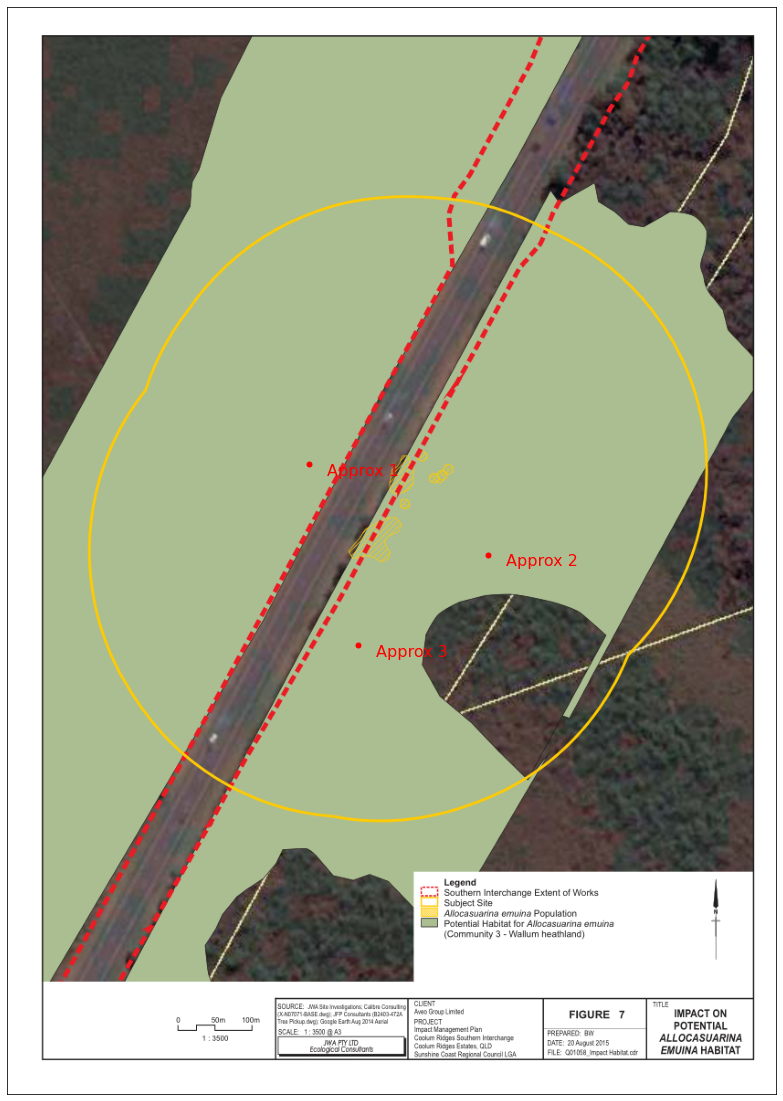

In [9]:
points = app.points
names = app.names

fig, ax = plt.subplots(1, figsize=(20,20))
ax.imshow(im1)
for i in range(len(points)):
    ax.plot(points[i][0], points[i][1], '.r', markersize=10)
    ax.text(points[i][0]+20, points[i][1]+12, names[i], color='r', fontsize=16)
    plt.tick_params(        
        which='both',     
        bottom=False,     
        top=False,
        left=False,
        right=False,
        labelbottom=False,
        labelleft=False
    )
fig.savefig(base_dir + sub_dir + '/reference.png')

if np.any([n not in json_names for n in names]):
    approx_lon = input(
        'Enter approx. lon. of top left map corner in dec. degrees '
        + '(e.g. 150.12345678): '
    )
    approx_lon = float(approx_lon)
    approx_lat = input(
        'Enter approx. lat. of top left map corner in signed dec. degrees '
        + '(e.g. -25.12345678): '
    )
    approx_lat = float(approx_lat)
    approx_spread = input(
        'Enter approx. width of map in dec. degrees (e.g. 0.05): '
    )
    approx_spread = float(approx_spread)

    # Here we can usually be more precise by centering on state of project
    scaled_points = [
        (
            approx_spread*x[0]/im1.shape[0] + approx_lon,
            -approx_spread*x[1]/im1.shape[1] + approx_lat
        ) for x in points
    ]

subprocess.run('rm -r ' + base_dir + sub_dir + '/JSON/raw', shell=True)
subprocess.run('mkdir -p ' + base_dir + sub_dir + '/JSON/raw', shell=True)
subprocess.run('mkdir -p ' + base_dir + sub_dir + '/JSON/edited', shell=True)

if np.any([n not in json_names for n in names]) or not json_names:
    json_features = []
    for i in range(len(scaled_points)):
        json_feature = geojson.Feature(
            geometry=geojson.Point(
                scaled_points[i], precision=8, properties={'Name': names[i]}
            )
        )
        json_features.append(json_feature)

    for i in range(len(json_features)):
        if names[i] not in json_names:
            f = open(base_dir + sub_dir + '/JSON/raw/' + names[i] + '.json', 'w')
            f.write(geojson.dumps(json_features[i], sort_keys=True, indent=4))
            f.close()

    subprocess.run(
        'cp ' + base_dir + '/reference.qgs ' + base_dir 
        + sub_dir + '/reference.qgs', shell=True
    )

    cmd=(
        'qgis --project ' + base_dir + sub_dir + '/reference.qgs ' 
        + base_dir + sub_dir + '/JSON/raw/*.json --extent {},{},{},{}'
    ).format(
        approx_lon, 
        approx_lat+np.sign(approx_lat)*approx_spread,
        approx_lon+approx_spread, 
        approx_lat-np.sign(approx_lat)*approx_spread,
    )
    subprocess.run(cmd, shell=True)

    subprocess.run(
        'mv ' + base_dir + sub_dir + '/JSON/raw/*json '
        + base_dir + sub_dir + '/JSON/edited/', shell=True
    )

coords = []
for i in range(len(points)):
    f = open(base_dir + sub_dir + '/JSON/edited/' + names[i] + '.json', 'r')
    coords.append(geojson.loads(f.read()))
    f.close()

rows = np.array([point[1] for point in points])
cols = np.array([point[0] for point in points])
lons = np.array(
    [coord['geometry']['coordinates'][0] for coord in coords]
)
lats = np.array(
    [coord['geometry']['coordinates'][1] for coord in coords]
)

X = cols/im1.shape[1]
Y = rows/im1.shape[0]

if len(rows) < 3:
    A = None
elif len(rows) < 5:
    A = lambda x,y: np.array([x*0+1, x, y])
else:
    A = lambda x,y: np.array([x*0+1, x, y, x**2, x*y, y**2])

c_lon, residuals, rank, s = np.linalg.lstsq(A(X,Y).T, lons, rcond=None)
c_lat, residuals, rank, s = np.linalg.lstsq(A(X,Y).T, lats, rcond=None)

def evaluate_paraboloid(x,y,coeff):
    c = copy.deepcopy(coeff)
    x = np.array(x)
    y = np.array(y)
    for i in range(len(x.shape)):
        c = np.expand_dims(c, axis=1)
    return (c*A(x,y)).sum(axis=0)

x = np.arange(im1.shape[1])/im1.shape[1]
y = np.arange(im1.shape[0])/im1.shape[0]
XX, YY = np.meshgrid(x, y)

LON = evaluate_paraboloid(XX, YY, c_lon)
LAT = evaluate_paraboloid(XX, YY, c_lat)

def hex_to_kml_hex(hex_col, with_hash=True, alpha='ff'):
    if with_hash:
        kml_hex = hex_col[1:]
    kml_hex = alpha + kml_hex[6:] + kml_hex[4:6] + kml_hex[2:4] + kml_hex[0:2]
    return kml_hex

poly_line=[]
poly_fill=[]
for i in range(len(svg_fill)):
    if svg_stroke[i] == 'none':
        poly_line.append(hex_to_kml_hex(svg_fill[i], alpha='ff'))
    else:
        poly_line.append(hex_to_kml_hex(svg_stroke[i], alpha='ff'))
    
    if svg_fill[i] == 'none':
        poly_fill.append(hex_to_kml_hex(svg_stroke[i], alpha='80'))
    else:
        poly_fill.append(hex_to_kml_hex(svg_fill[i], alpha='80'))

subprocess.run(
    'mkdir ' + base_dir + sub_dir + '/' + str(page_num), 
    shell=True
)

subprocess.run(
    'rm ' + base_dir + sub_dir + '/' + str(page_num) 
    + '/svg.kml', shell=True
)

def gen_poly_coords(coords, LON, LAT):
    poly_coords = [
        [
            (
                LON[
                    coords[i][j][0][1],
                    coords[i][j][0][0]
                ],
                LAT[
                    coords[i][j][0][1],
                    coords[i][j][0][0]
                ],
                1.0
            )
            for j in range(len(coords[i]))
        ]
        for i in range(len(coords))
    ]
    return poly_coords

kml = simplekml.Kml()
kml.document.name = str(page_num) + '_svg'

styles = []
for i in range(len(svg_coords)):
    sty = simplekml.Style()
    sty.linestyle.width = 2
    sty.linestyle.color = poly_line[i]
    sty.polystyle.color = poly_fill[i]
    styles.append(sty)
            
poly_coords = gen_poly_coords(svg_coords, LON, LAT)

for name in set(poly_names):
    fol = kml.newfolder(name=name)
    poly_inds = np.where(np.array(poly_names)==name)[0].tolist()
    for j in range(len(poly_inds)):
        if poly_coords[poly_inds[j]][0] == poly_coords[poly_inds[j]][-1]:
            poly = fol.newpolygon(
                name = name + ' ' + str(j+1),
                outerboundaryis = poly_coords[poly_inds[j]],
                altitudemode='relativetoground',                
            )
        else:
            poly = fol.newlinestring(
                name = name + ' ' + str(j+1),
                coords = poly_coords[poly_inds[j]],
                altitudemode='relativetoground',              
            )
        poly.style = styles[poly_inds[j]]

if cp_coords:
    unique_cp_names = list(set(cp_names))
    num_colours = len(unique_cp_names)
    alpha=0.75
    cm = pylab.get_cmap('Set1')
    poly_colours = []
    line_colours = []

    for i in range(num_colours):
        cp = list(cm(1.*i/num_colours))
        cline = copy.deepcopy(cp)
        cp[3] = alpha
        cp = to_hex(cp, keep_alpha=True)[1:]
        cp = cp[6:]+cp[4:6]+cp[2:4]+cp[0:2]
        poly_colours.append(cp)
        cline = (np.array(cline)*0.8).tolist()
        cline[3] = alpha

        cline = to_hex(cline, keep_alpha=True)[1:]
        cline = cline[6:]+cline[4:6]+cline[2:4]+cline[0:2]
        line_colours.append(cline)

    styles = {}
    for i in range(len(unique_cp_names)):
        sty = simplekml.Style()
        sty.linestyle.width = 2
        sty.linestyle.color = poly_line[i]
        sty.polystyle.color = poly_fill[i]
        styles[unique_cp_names[i]]= sty
    
    poly_coords = gen_poly_coords(cp_coords, LON, LAT)

    for name in unique_cp_names:
        fol = kml.newfolder(name=name)
        poly_inds = np.where(np.array(cp_names)==name)[0].tolist()
        for j in range(len(poly_inds)):
            if poly_coords[poly_inds[j]][0] == poly_coords[poly_inds[j]][-1]:
                poly = fol.newpolygon(
                    name = name + ' ' + str(j+1),
                    outerboundaryis = poly_coords[poly_inds[j]],
                    altitudemode='relativetoground',                
                )
            else:
                poly = fol.newlinestring(
                    name = name + ' ' + str(j+1),
                    coords = poly_coords[poly_inds[j]],
                    altitudemode='relativetoground',              
                )
            poly.style = styles[name]
kml.save(
    base_dir + sub_dir + '/' 
    + str(page_num) + '/svg.kml'
)

subprocess.run(
    'cp ' + base_dir + '/reference.qgs ' + base_dir 
    + sub_dir + '/reference.qgs', shell=True
)

cmd=(
    'qgis --project ' + base_dir + sub_dir + '/reference.qgs ' 
    + base_dir + sub_dir + '/' + str(page_num) 
    + '/svg.kml --extent {},{},{},{}'
).format(np.min(LON), np.min(LAT), np.max(LON), np.max(LAT))

subprocess.run(cmd, shell=True)

## Extract from image

['No label', 'Development site " )']


CompletedProcess(args='qgis --project /home/student.unimelb.edu.au/shorte1/Documents/ACF_consulting/map_data/20167684_07042016/reference.qgs /home/student.unimelb.edu.au/shorte1/Documents/ACF_consulting/map_data/20167684_07042016/131/image.kml --extent 150.59544603508846,-33.90475348892866,150.61301193248843,-33.89371379224609', returncode=0)

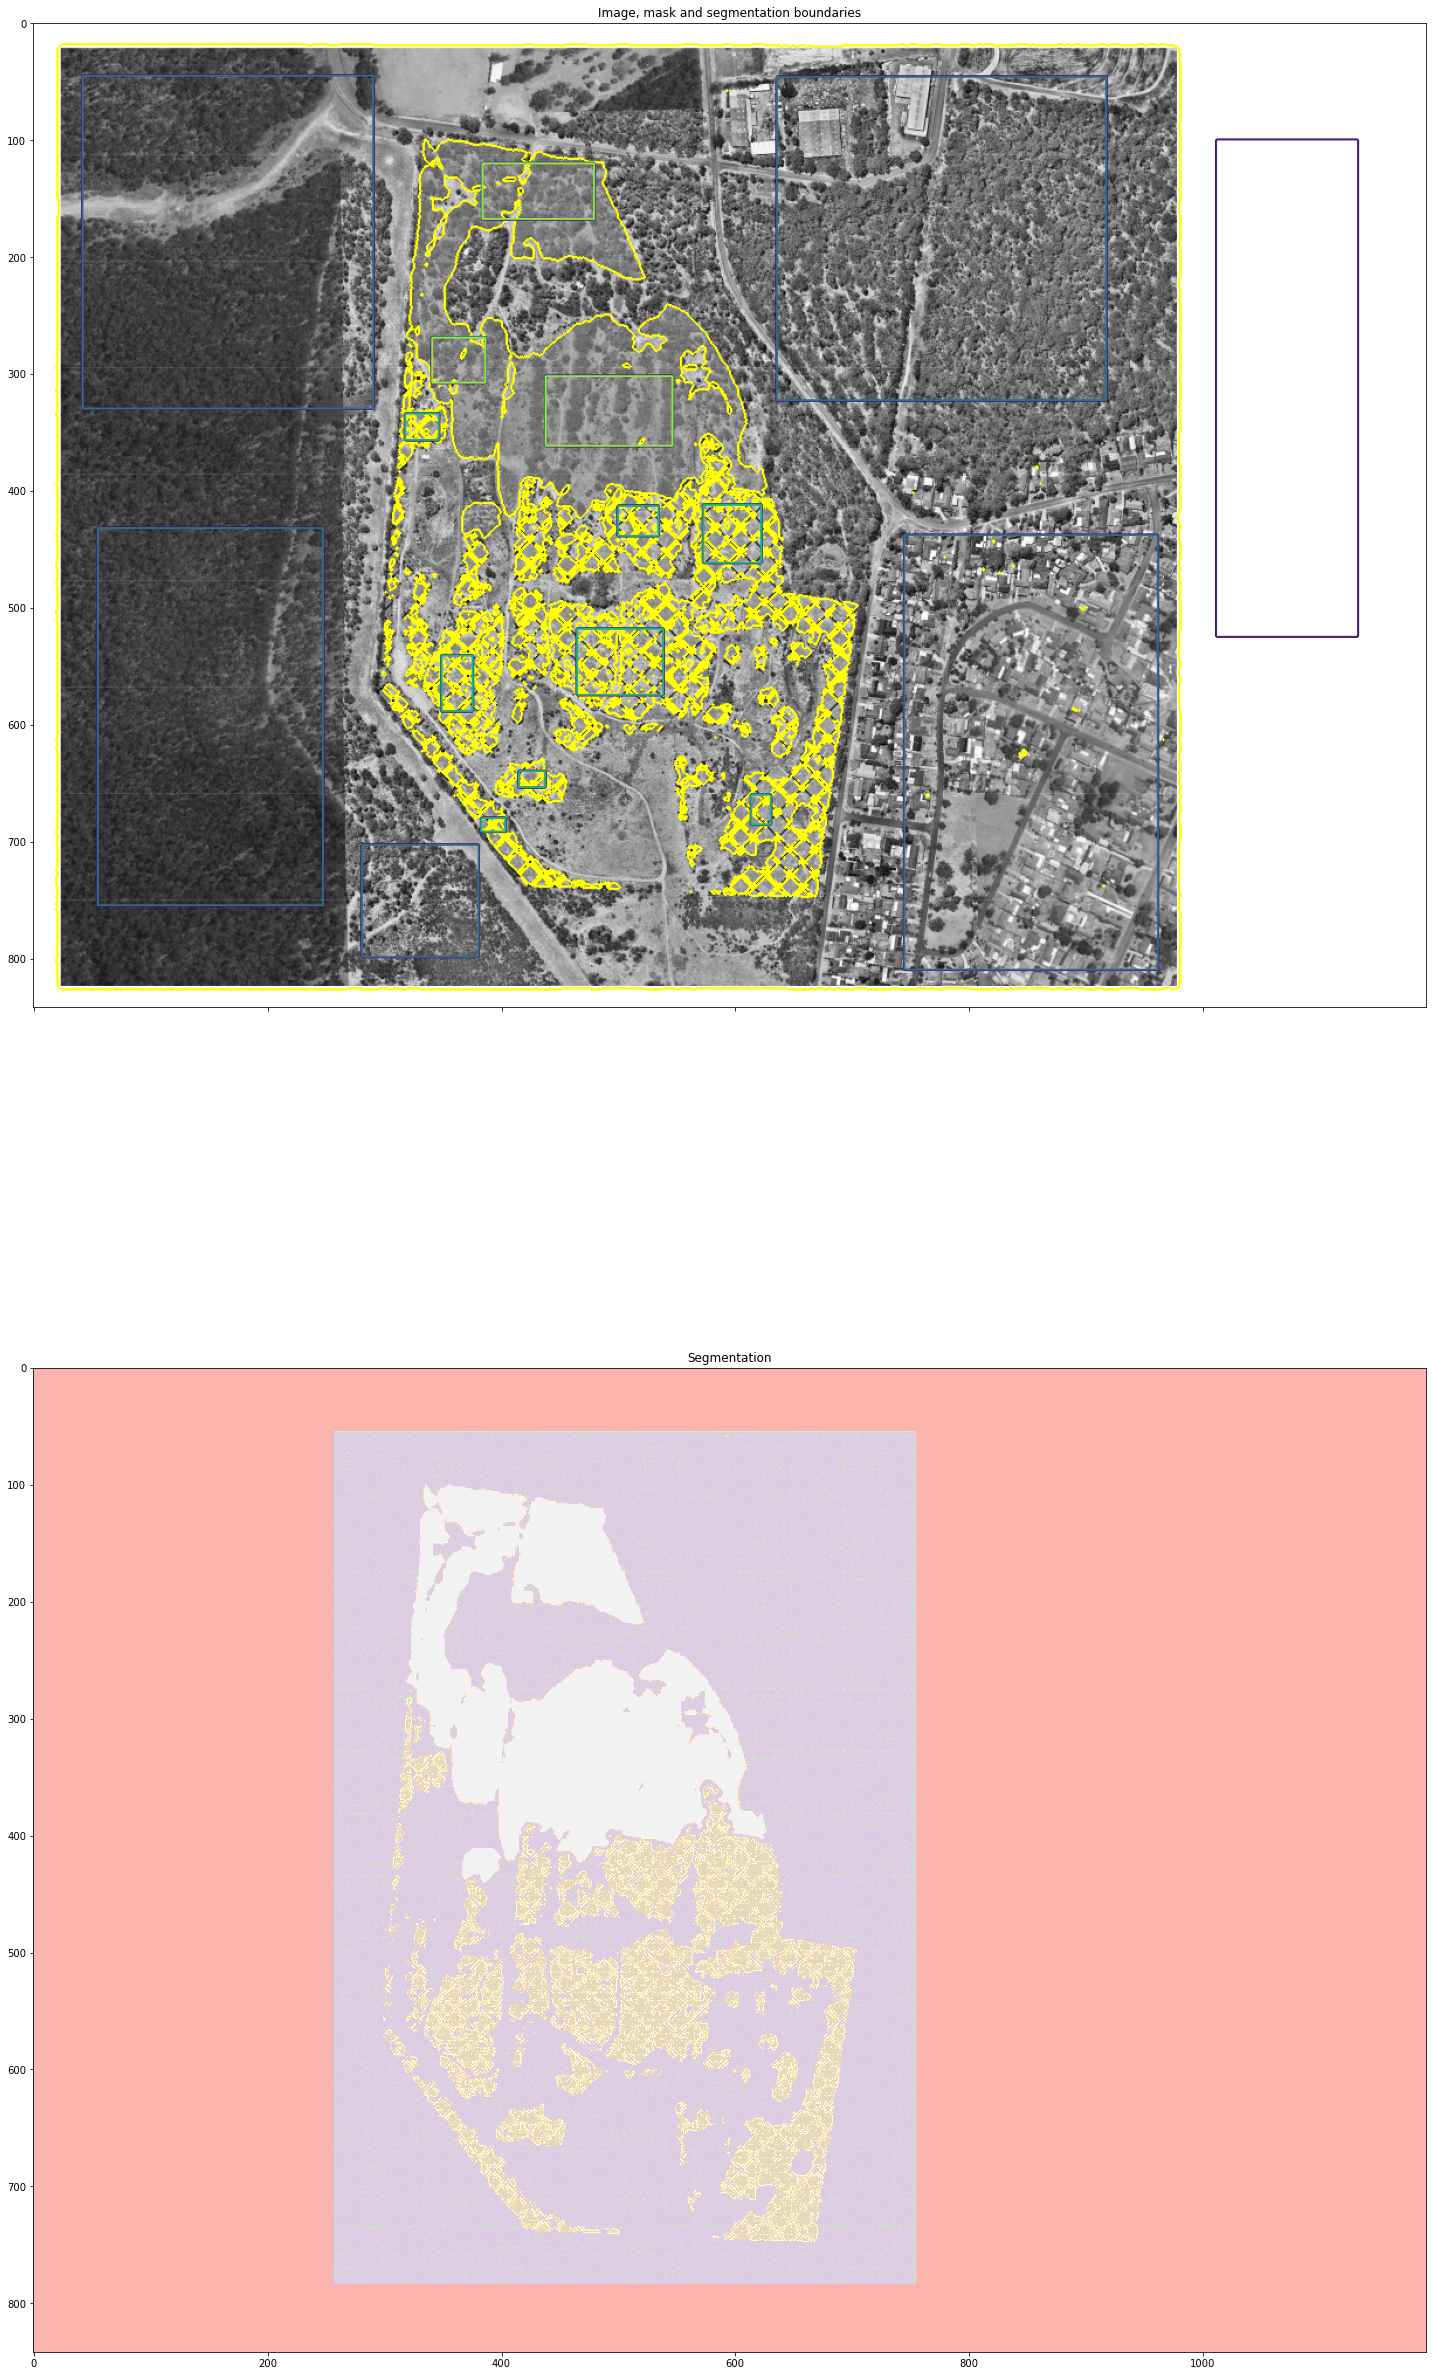

In [33]:
small_soup = BeautifulSoup(svg)

f = open(
    base_dir + sub_dir + '/' + str(page_num) + '/full_image.svg', 'w')
f.write(soup_tap.svg.prettify())
f.close()

[s.decompose() for s in small_soup('path')]
[s.decompose() for s in small_soup('text')]

for s in small_soup('image'):
    transform = convert_transform(s.parent.parent['transform'])
    img_width = abs(float(s['width'])*transform[0,0])
    img_height = abs(float(s['height'])*transform[1,1])
    if img_width > 0.6*p_width:
        continue
    elif img_height > 0.6*p_height:
        continue
    s.decompose()
    
fname = base_dir + sub_dir + '/' + str(page_num) + '/no_overlays.svg'
f = open(fname, 'w')
f.write(small_soup.svg.prettify())
f.close()

cmd = (
    'inkscape {} --export-filename={} '
    + '--export-background=FFFFFFFF --export-area=0:0:{}:{}'
).format(
    fname, base_dir + sub_dir + '/' + str(page_num) + '/no_overlays.png',
    np.ceil(p_width).astype(int), np.ceil(p_height).astype(int)
)
subprocess.run(cmd, shell=True)

im1 = imread(base_dir + sub_dir + '/' + str(page_num) + '/no_overlays.png')

try:
    print(cp_names)
except:
    cp_names = []

root = tk.Tk()
# root.attributes('-zoomed', True)
app = gui.Define_Training_Regions(
    root, im1, list(set(leg_text_all + cp_names)), 
    legend=leg_im
)
root.mainloop()

training_labels = np.zeros(im1.shape[:2])
for i in range(len(app.boxes)):
    for box in app.boxes[i]:
        training_labels[box[1]:box[3], box[0]:box[2]] = i+1

sigma_min = 1
sigma_max = 2
features_func = partial(feature.multiscale_basic_features,
                        intensity=True, edges=False, texture=True,
                        sigma_min=sigma_min, sigma_max=sigma_max,
                        multichannel=True)
features = features_func(im1)
clf = RandomForestClassifier(n_estimators=50, n_jobs=-1,
                             max_depth=10, max_samples=0.05)
clf = future.fit_segmenter(training_labels, features, clf)
result = future.predict_segmenter(features, clf)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(20, 40))
gray = cv.cvtColor(im1, cv.COLOR_BGR2GRAY)
ax[0].imshow(segmentation.mark_boundaries(gray, result, mode='thick'))
ax[0].contour(training_labels)
ax[0].set_title('Image, mask and segmentation boundaries')

poly_box = np.zeros(im1.shape[:2])
poly_box[pb_tl[1]:pb_br[1], pb_tl[0]:pb_br[0]]=1
poly_box = poly_box.astype(bool)
poly_box = np.logical_not(poly_box)
result[poly_box] = 1

ax[1].imshow(result, cmap='Pastel1')
ax[1].set_title('Segmentation')
fig.tight_layout()

root = tk.Tk()
app_choose = gui.Choose_Kept_Categories(
    root, app.names
)
root.mainloop()

result = median(result, selem=np.ones([15,15]))

inds = (np.where([v.get() for v in app_choose.v])[0]+1).tolist()

poly_colours = []
line_colours = []
alpha='80'
for i in inds:
    cp = im1[result==i].mean(axis=0)/255
    cp = to_hex(cp, keep_alpha=True)[1:]
    cp = cp[6:]+cp[4:6]+cp[2:4]+cp[0:2]
    line_colours.append(cp)
    cp_fill = copy.deepcopy(cp)
    cp_fill = alpha + cp_fill[2:]
    poly_colours.append(cp_fill)

kml = simplekml.Kml()
kml.document.name = str(page_num) + '_image'

styles = []
for i in range(len(inds)):
    sty = simplekml.Style()
    sty.linestyle.width = 2
    sty.linestyle.color = line_colours[i]
    sty.polystyle.color = poly_colours[i]
    styles.append(sty)
    
for i in range(len(inds)):
    filled = ndi.binary_fill_holes(result==inds[i])
    obj_size_ratio = 5e-5
    min_size = int(obj_size_ratio*im1.shape[0]*im1.shape[1])
    filled = remove_small_objects(filled, min_size = min_size)
    filled = ndi.binary_fill_holes(filled)
    
    label_objects, nb_labels = ndi.label(filled)
    label_objects = label_objects.astype(np.uint8)
    
    obj_contours, hierarchy = cv.findContours(
        label_objects, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_TC89_L1
    )
    
    smooth_obj_contours = []
    for cnt in obj_contours:
        if len(cnt) > 3:
            epsilon = 0.0001*cv.arcLength(cnt,True)
            smooth_obj_contours.append(
                cv.approxPolyDP(cnt,epsilon,True)
            )
            
    poly_coords = gen_poly_coords(smooth_obj_contours, LON, LAT)
    
    if poly_coords:
        fol = kml.newfolder(name=app.names[inds[i]-1])
        for j in range(len(poly_coords)):
            poly = fol.newpolygon(
                name = name + ' ' + str(j+1),
                outerboundaryis = poly_coords[j] + [poly_coords[j][0]],
                altitudemode='relativetoground',                
            )
            poly.style = styles[i]
kml.save(base_dir + sub_dir + '/' + str(page_num) + '/image.kml')

subprocess.run(
    'cp ' + base_dir + '/reference.qgs ' + base_dir 
    + sub_dir + '/reference.qgs', shell=True
)

cmd=(
    'qgis --project ' + base_dir + sub_dir + '/reference.qgs ' 
    + base_dir + sub_dir + '/' + str(page_num) 
    + '/image.kml --extent {},{},{},{}'
).format(np.min(LON), np.min(LAT), np.max(LON), np.max(LAT))

subprocess.run(cmd, shell=True)